In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)


Project root added: d:\ML projects\player-behavior-sequence-modeling


In [2]:
from src.model import PlayerBehaviourLSTM
from src.dataset import PlayerSequenceDataset
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
sequences_path = os.path.join(PROJECT_ROOT, "data", "processed", "sequences.npy")
masks_path = os.path.join(PROJECT_ROOT, "data", "processed", "masks.npy")

dataset = PlayerSequenceDataset(sequences_path, masks_path)

print(len(dataset))


100


In [4]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [5]:
model = PlayerBehaviourLSTM(
    num_actions=10,
    embedding_dim=32,
    hidden_dim=64
).to(device)

model.eval()

embeddings = []

with torch.no_grad():
    for batch in loader:
        x = batch["sequence"].to(device)
        h = model(x)
        embeddings.append(h.cpu())

embeddings = torch.cat(embeddings, dim=0)

print("Embeddings shape:", embeddings.shape)

Embeddings shape: torch.Size([100, 64])


In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings.numpy())

print("2D shape:", emb_2d.shape)


2D shape: (100, 2)


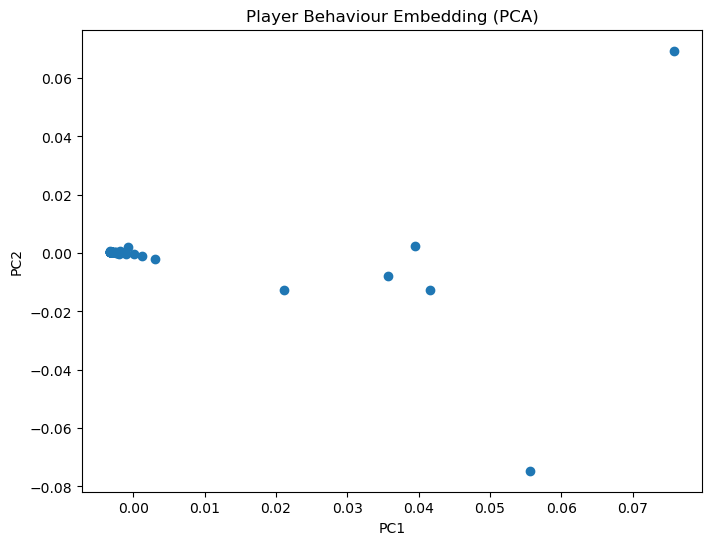

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.title("Player Behaviour Embedding (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings.numpy())

print("Cluster labels shape:", cluster_labels.shape)


Cluster labels shape: (100,)


c:\Users\kumar\anaconda3\envs\pytorch_dl\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


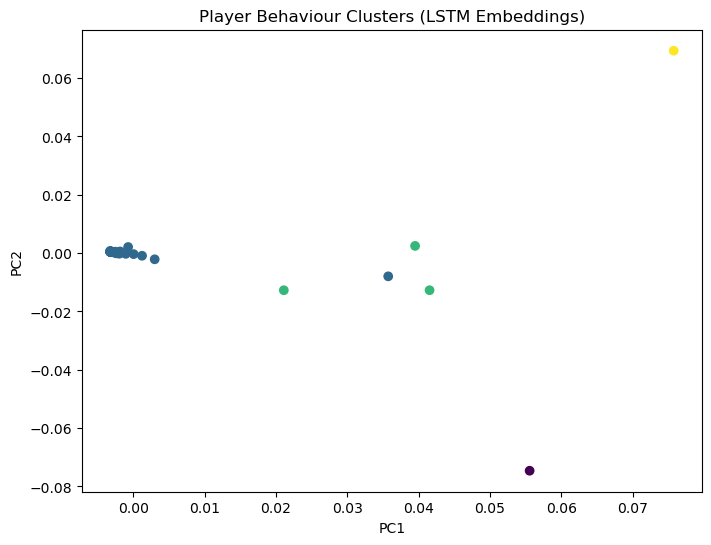

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_labels)
plt.title("Player Behaviour Clusters (LSTM Embeddings)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [10]:
import pandas as pd

df_raw = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "raw", "players.csv"))

behavior_per_player = (
    df_raw.groupby("player_id")["behavior_type"]
    .first()
)

true_labels = behavior_per_player.values

print("True labels shape:", true_labels.shape)


True labels shape: (100,)


In [11]:
import numpy as np

unique_behaviors = np.unique(true_labels)
behavior_to_id = {b: i for i, b in enumerate(unique_behaviors)}
true_ids = np.array([behavior_to_id[b] for b in true_labels])


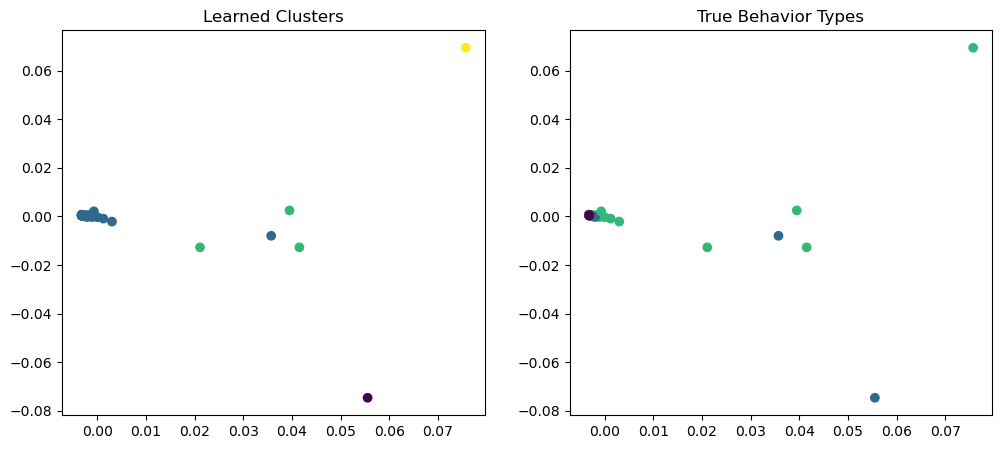

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_labels)
plt.title("Learned Clusters")

plt.subplot(1,2,2)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=true_ids)
plt.title("True Behavior Types")

plt.show()


In [13]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(true_ids, cluster_labels)
print("Adjusted Rand Index:", ari)


Adjusted Rand Index: -0.004620216325737749


In [14]:
df_raw = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "raw", "players.csv"))

behavior_per_player = (
    df_raw.groupby("player_id")["behavior_type"]
    .first()
)

true_labels = behavior_per_player.values

unique_behaviors = np.unique(true_labels)
behavior_to_id = {b: i for i, b in enumerate(unique_behaviors)}
label_ids = np.array([behavior_to_id[b] for b in true_labels])

print("Unique behaviors:", unique_behaviors)
print("Label shape:", label_ids.shape)

Unique behaviors: ['aggressive' 'casual' 'explorer' 'quitter']
Label shape: (100,)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class SupervisedPlayerDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


sequences_tensor = torch.tensor(np.load(sequences_path), dtype=torch.long)

supervised_dataset = SupervisedPlayerDataset(sequences_tensor, label_ids)

loader = DataLoader(supervised_dataset, batch_size=16, shuffle=True)


In [17]:
from src.model import PlayerBehaviorClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PlayerBehaviorClassifier(
    num_actions=10,
    num_classes=len(unique_behaviors),
    embedding_dim=32,
    hidden_dim=64
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}: Loss {total_loss/len(loader):.4f}, Accuracy {acc:.4f}")


Epoch 1: Loss 1.3995, Accuracy 0.2400
Epoch 2: Loss 1.3839, Accuracy 0.2400
Epoch 3: Loss 1.3859, Accuracy 0.2300
Epoch 4: Loss 1.3817, Accuracy 0.3100
Epoch 5: Loss 1.3766, Accuracy 0.3600
Epoch 6: Loss 1.3493, Accuracy 0.3500
Epoch 7: Loss 1.3145, Accuracy 0.3000
Epoch 8: Loss 1.2971, Accuracy 0.3000
Epoch 9: Loss 1.1699, Accuracy 0.4100
Epoch 10: Loss 1.1457, Accuracy 0.4900
Epoch 11: Loss 0.9958, Accuracy 0.6100
Epoch 12: Loss 0.9325, Accuracy 0.6100
Epoch 13: Loss 0.8483, Accuracy 0.6300
Epoch 14: Loss 0.7341, Accuracy 0.6700
Epoch 15: Loss 0.8888, Accuracy 0.7400
Epoch 16: Loss 0.8581, Accuracy 0.7100
Epoch 17: Loss 0.8261, Accuracy 0.7100
Epoch 18: Loss 0.6992, Accuracy 0.7300
Epoch 19: Loss 0.6407, Accuracy 0.7500
Epoch 20: Loss 0.6556, Accuracy 0.7400


In [18]:
model.eval()

embeddings = []

with torch.no_grad():
    for x, _ in loader:
        x = x.to(device)
        h = model.backbone(x)
        embeddings.append(h.cpu())

embeddings = torch.cat(embeddings, dim=0)
print("New embeddings shape:", embeddings.shape)


New embeddings shape: torch.Size([100, 64])


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=len(unique_behaviors), random_state=42)
cluster_labels = kmeans.fit_predict(embeddings.numpy())

ari = adjusted_rand_score(label_ids, cluster_labels)
print("New Adjusted Rand Index:", ari)


New Adjusted Rand Index: 0.01869673302779724


c:\Users\kumar\anaconda3\envs\pytorch_dl\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [20]:
eval_loader = DataLoader(
    supervised_dataset,
    batch_size=16,
    shuffle=False   # IMPORTANT
)


In [21]:
model.eval()

embeddings = []
ordered_labels = []

with torch.no_grad():
    for x, y in eval_loader:
        x = x.to(device)
        h = model.backbone(x)
        embeddings.append(h.cpu())
        ordered_labels.append(y)

embeddings = torch.cat(embeddings, dim=0)
ordered_labels = torch.cat(ordered_labels, dim=0).numpy()


In [22]:
kmeans = KMeans(n_clusters=len(unique_behaviors), random_state=42)
cluster_labels = kmeans.fit_predict(embeddings.numpy())

ari = adjusted_rand_score(ordered_labels, cluster_labels)
print("Corrected ARI:", ari)


Corrected ARI: 0.5346064462223836


c:\Users\kumar\anaconda3\envs\pytorch_dl\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


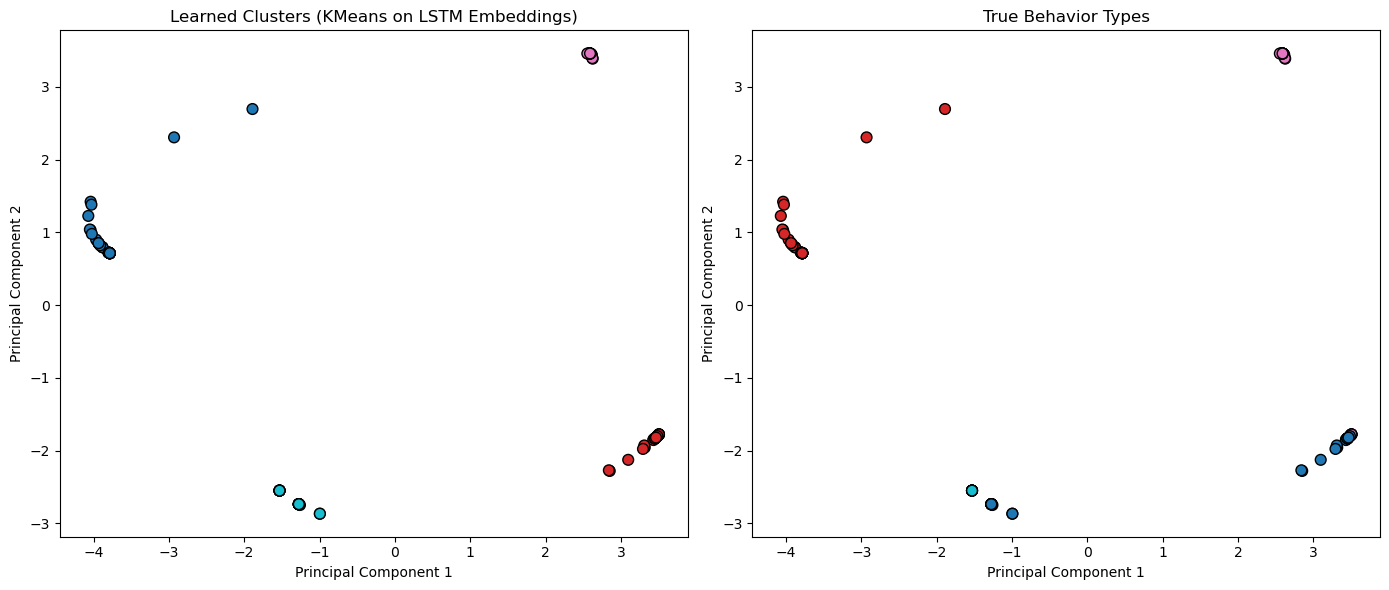

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce to 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings.numpy())

# Improve figure quality
plt.figure(figsize=(14, 6))

# Plot 1 — Learned Clusters
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=cluster_labels,
    cmap="tab10",
    s=60,
    edgecolors="k"
)
plt.title("Learned Clusters (KMeans on LSTM Embeddings)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot 2 — True Labels
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=ordered_labels,
    cmap="tab10",
    s=60,
    edgecolors="k"
)
plt.title("True Behavior Types")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()
